In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import torch
import torchvision.transforms as transforms

In [2]:
# Import relevant scikit-learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import AdaBoostRegressor
from scipy import stats
import os
from torch.nn.modules import padding
import random
import utils

In [3]:
# 是否读取之前的划分
new_split = 0

In [4]:
np.seterr(divide='ignore',invalid='ignore')

# Define path and csv files
DATA_DIR = '../data/19_science/'
# OUT_DIR = 'out/models_unimol_infer'+datetime.now().strftime('%y%m%d%H%M')+'/'
OUT_DIR = 'out/models_unimol_infer2405071951/'
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)
# 分子特征
INPUTS_Catlyst_repr = 'Catalyst_smirepr.csv'  # Unscaled  data 
INPUTS_Imine_repr = 'Imine_smirepr.csv'
INPUTS_Thiol_repr = 'Thiol_smirepr.csv'
INPUTS_Origin_DF = '19_science_total.csv'

inputs_Catlyst_repr = pd.read_csv(DATA_DIR + INPUTS_Catlyst_repr)
inputs_Imine_repr = pd.read_csv(DATA_DIR + INPUTS_Imine_repr)
inputs_Thiol_repr = pd.read_csv(DATA_DIR + INPUTS_Thiol_repr)
delta_G = pd.read_csv(DATA_DIR + INPUTS_Origin_DF)['Output']

inputs = np.concatenate([inputs_Catlyst_repr,inputs_Imine_repr,inputs_Thiol_repr],axis=1)

In [5]:
if new_split == 1:
    # 随机生成train和test的indices
    total_cleaned_len = len(inputs_Catlyst_repr)
    train_index = random.sample(range(total_cleaned_len), 600)#论文中用了600个作为训练集 int(1075*0.7)
    train_indices = np.zeros((total_cleaned_len)).astype(np.bool)
    for tcl in range(total_cleaned_len):
        if tcl in train_index:
            train_indices[tcl] = True
    test_indices = ~ train_indices
    np.savetxt(OUT_DIR + 'clean_data_train_indices.csv', train_indices, delimiter = ',')
    np.savetxt(OUT_DIR + 'clean_data_test_indices.csv', test_indices, delimiter = ',')

elif new_split == 0:
    # read saved train indices and test indices
    train_indices = np.loadtxt(OUT_DIR + 'clean_data_train_indices.csv',dtype='bool', delimiter=',')
    test_indices = np.loadtxt(OUT_DIR + 'clean_data_test_indices.csv',dtype='bool', delimiter=',')

    # Load yield data
    delta2G = np.array(delta_G)
    delta2G = delta2G.flatten()
    delta2G = np.nan_to_num(delta2G, nan=0)
    print('len(inputs): ', len(inputs))
    # Use the indices to generate train/test sets
    X_train = inputs[train_indices]
    #X_train = inputs[:2]
    y_train = delta2G[train_indices]
    featuresTrain = torch.from_numpy(X_train)
    targetsTrain = torch.from_numpy(y_train)
    batch_size = len(X_train)
    print('batch_size: ', batch_size)

    X_test = inputs[test_indices]
    y_test = delta2G[test_indices]
    featuresTest = torch.from_numpy(X_test)
    targetsTest = torch.from_numpy(y_test)#.type(torch.LongTensor)
    batch_size_test = len(X_test)
    print('batch_size_test: ', batch_size_test)

    train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
    test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size_test, shuffle = False)

len(inputs):  1075
batch_size:  600
batch_size_test:  475


RandomForestRegressor(n_estimators=50, random_state=42)
Done fitting models


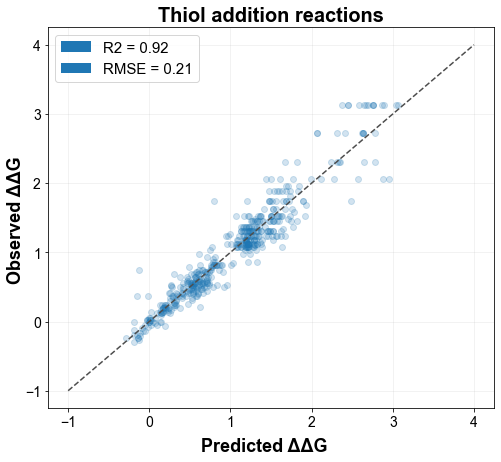

In [6]:
# fit model and draw figure
models_need_fit = [    
          RandomForestRegressor(n_estimators=50,random_state=42),    
          #RandomForestRegressor(n_estimators=100,random_state=42)#,
         ]
models_already_fitted = []
preds, r2_values, rmse_values  = utils.load_or_fit_models(X_train,
                                                  X_test,
                                                  y_train,
                                                  y_test,
                                                  models_need_fit, models_already_fitted)

# create subplot
fig = plt.figure(figsize=(8,7))
plt.rcParams['font.family'] = 'Arial'
plt.grid(alpha=0.2)
plt.title('Thiol addition reactions', fontsize=20, weight = 'bold')
# colors=list(mcolors.TABLEAU_COLORS.keys())
# add score patches
r2_patch = mpatches.Patch(label="R2 = {:04.2f}".format(r2_values[0]))
rmse_patch = mpatches.Patch(label="RMSE = {:4.2f}".format(rmse_values[0]))
# plt.xlim(-40,130)
# plt.ylim(-10,130)
plt.scatter(preds[0], y_test, alpha=0.2,)
plt.legend(handles=[r2_patch, rmse_patch], fontsize=15,loc='upper left')
plt.plot(np.arange(-1,5), np.arange(-1,5), ls="--", c=".3")
plt.yticks( size = 14)
plt.xticks( size = 14)
fig.text(0.5, 0.05, 'Predicted ΔΔG', ha='center', va='center', fontsize=18, weight = 'bold')
fig.text(0.07, 0.5, 'Observed ΔΔG', ha='center', va='center', rotation='vertical', fontsize=18, weight = 'bold')
plt.savefig(OUT_DIR +'results.png', dpi = 300)